In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(0)

In [3]:
# Import data
classes = 100
tf = [transforms.Grayscale()]
train = datasets.get_cifar(classes, transform=tf)
test = datasets.get_cifar(classes, transform=tf, train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Set training parameters and loader
batch_size = 32
epochs = 20
nu = 7.5e-5
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'pie_dense_deblur_ls_od'

In [4]:
# Generate Blur
blur = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur.weight.data[...] = 1/9
blur.weight.requires_grad = False;

# Generate GPU version
blur_gpu = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur_gpu.weight.data[...] = 1/9
blur_gpu.weight.requires_grad = False;
blur_gpu.to(device);

In [5]:
# Initialize dimensions, models, parameters and optimizers
dims = [M, 2*M, M]

model_kwargs = {
    'activation': modules.BiCELU,
    'activation_params': {},
    'device': device
}

nets = {
    "PIE": models.dense.AdjointDense(dims, diagonal=False, **model_kwargs),
    "PIED": models.dense.AdjointDense(dims, diagonal=True, **model_kwargs),
    "AE": models.dense.AEDense(dims, diagonal=False, **model_kwargs),
}

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)

In [6]:
# Define objective function

def objective_function(x, xh, y, yh, params=None, l2_lambda=1e-6, alpha=4, reduction='mean'):
    losses = {}

    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    losses['lx'] = utils.loss.logcosh(xh, x, alpha=4, reduction=reduction)
    losses['ly'] = utils.loss.logcosh(yh, y, alpha=4, reduction=reduction)
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [7]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:5}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params PIE  :  4197376
No. params PIED :  4199424
No. params AE   :  8394752


In [8]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.tensor(train.data[sample_indices_small]).float().mean(-1) / 255
yims = blur(xims[:,None,...])
xs = xims.flatten(-2, -1).to(device)
ys = yims.flatten(-3, -1).to(device)
xt = torch.tensor(test.data).float().mean(-1).flatten(-2, -1).to(device) / 255
yt = blur((torch.tensor(test.data).float().permute(0,3,1,2).mean(1)[:,None,...] / 255)).flatten(-3, -1).to(device)

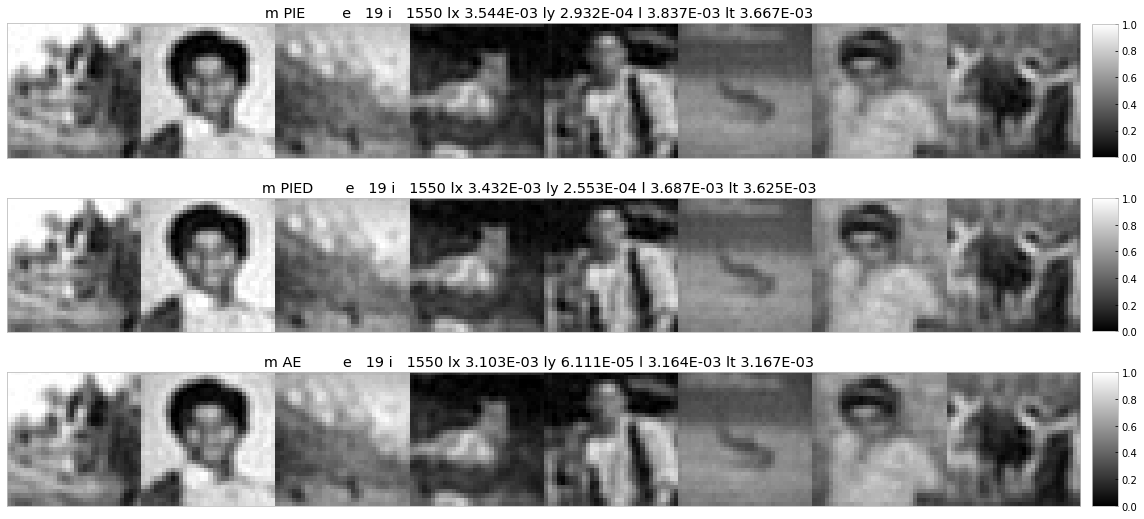

In [9]:
# Training loop

for e in range(epochs):
    i = 0
    for x, _ in loader:
        x = x.to(device)
        with torch.no_grad():
            y = blur_gpu(x).flatten(-3, -1)
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()
            yh = nets[cur](x)
            xh = nets[cur].T(y)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh, y, yh)

            loss.backward()
            opts[cur].step()
            
            # Validation
            with torch.no_grad():
                yth = nets[cur](xt)
                xth = nets[cur].T(yt)
                ldicts[cur]['lt'] = utils.loss.logcosh(xth, xt, alpha=4, reduction='mean')

            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 50 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    yhs = nets[cur](xs)
                    xhs[cur] = nets[cur].T(yhs)
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, cmap='gray', path=experiment_name)
            
        i += 1

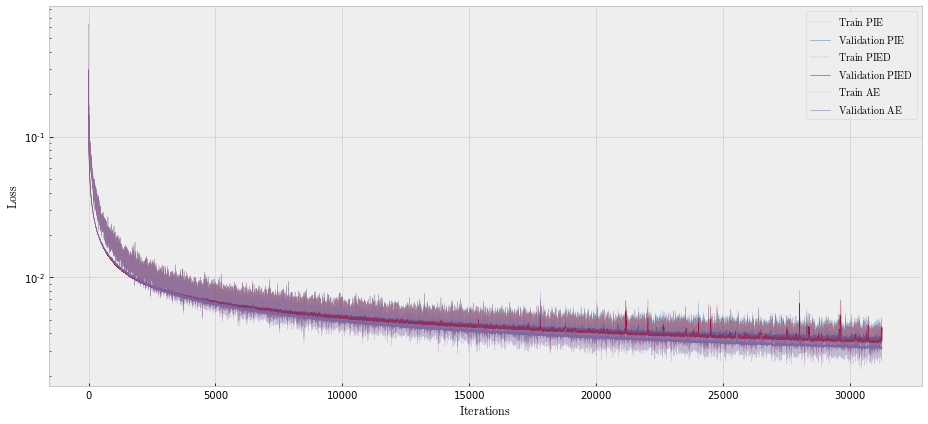

In [10]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    p = plt.plot(np_loss_trace[k]["l"], linewidth=.3, label=f"$\mathrm{{Train\,\,{k}}}$", alpha=0.4)
    plt.plot(np_loss_trace[k]["lt"], linewidth=.5, label=f"$\mathrm{{Validation\,\,{k}}}$", alpha=0.95, color=p[0].get_color())

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

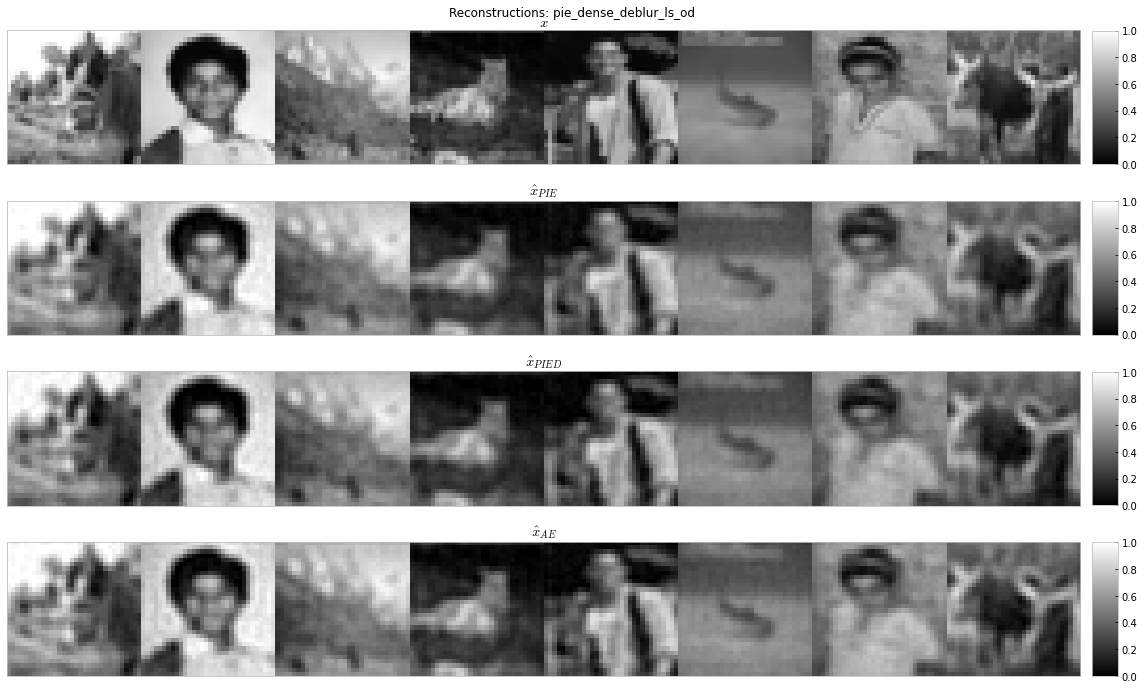

In [11]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        xhs[k] = nets[k].T(ys)
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
    
utils.reporting.plot_results(xhs, f'Reconstructions: {experiment_name}', cmap='gray', fname=experiment_name)

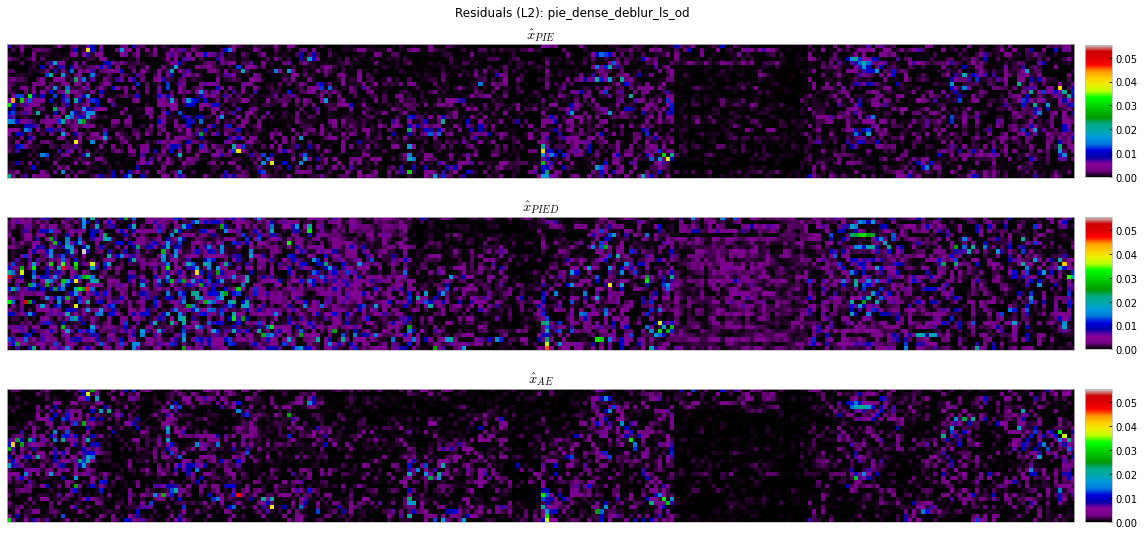

In [12]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for k in nets.keys():
        xhs[k] = nets[k].T(nets[k](xs))
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
        xhs[k] = (xhs[k] - xims)**2
        if torch.max(xhs[k]) > curmax:
            curmax = torch.max(xhs[k])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [13]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [14]:
print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(yt.cpu())
        YH = model(xt.cpu())
        re_x = utils.metrics.relative_error(XH, xt.cpu(), reduction='mean')
        re_y = utils.metrics.relative_error(YH, yt.cpu(), reduction='mean')
        mse_x = F.mse_loss(XH, xt.cpu(), reduction='mean')
        mse_y = F.mse_loss(YH, yt.cpu(), reduction='mean')
    print(
        f"{k:6}: " + 
        f"REx {re_x:4E} " +
        f"REy {re_y:4E} " +
        f"RE  {(re_x + re_y) / 2:4E} " +
        f"MSEx {mse_x:4E} " + 
        f"MSEy {mse_y:4E} " +
        f"MSE  {(mse_x + mse_y) / 2:4E} "
    )

Relative Error:
PIE   : REx 8.501320E-02 REy 2.706391E-02 RE  5.603855E-02 MSEx 1.888360E-03 MSEy 1.755382E-04 MSE  1.031949E-03 
PIED  : REx 9.710738E-02 REy 3.839245E-02 RE  6.774992E-02 MSEx 2.262027E-03 MSEy 3.607071E-04 MSE  1.311367E-03 
AE    : REx 7.913310E-02 REy 1.896252E-02 RE  4.904781E-02 MSEx 1.632430E-03 MSEy 9.470145E-05 MSE  8.635658E-04 


In [15]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(yt.cpu())
        YH = model(xt.cpu())
        psnr_x = utils.metrics.psnr(xt.cpu(), XH)
        ssim_x = utils.metrics.ssim(
            xt.cpu().unflatten(-1, (32, 32))[:,None,...], 
            XH.unflatten(-1, (32, 32))[:,None,...]
        )
        psnr_y = utils.metrics.psnr(yt.cpu(), YH)
        ssim_y = utils.metrics.ssim(
            yt.cpu().unflatten(-1, (32, 32))[:,None,...], 
            YH.unflatten(-1, (32, 32))[:,None,...]
        )
    print(
        f"{k:6}: " + 
        f"PSNRx: {psnr_x:4E} " +
        f"PSNRy: {psnr_y:4E} " +
        f"PSNR:  {(psnr_y + psnr_x) / 2:4E} " +
        f"SSIMx: {ssim_x:4E} " +
        f"SSIMy: {ssim_y:4E} " +
        f"SSIM:  {(ssim_y + ssim_x) / 2:4E} "
    )

Image Reconstruction Metrics:
PIE   : PSNRx: 2.723915E+01 PSNRy: 3.755628E+01 PSNR:  3.239772E+01 SSIMx: 9.212239E-01 SSIMy: 9.833632E-01 SSIM:  9.522936E-01 
PIED  : PSNRx: 2.645502E+01 PSNRy: 3.442845E+01 PSNR:  3.044174E+01 SSIMx: 9.215391E-01 SSIMy: 9.840235E-01 SSIM:  9.527813E-01 
AE    : PSNRx: 2.787165E+01 PSNRy: 4.023643E+01 PSNR:  3.405405E+01 SSIMx: 9.299312E-01 SSIMy: 9.948472E-01 SSIM:  9.623892E-01 


In [16]:
test_tensor = xt.cpu()

# Compute Estimated Generalized Inverses
Ids = {}
for k, model in nets.items():
    with torch.no_grad():
        dct = model.get_weight_dict()
        if model.diagonal:
            Ids[k] = dct['V.T'] @ dct['D.T'] @ dct['U.T'] @ dct['U'] @ dct['D'] @ dct['V']
        else:
            Ids[k] = dct['V.T'] @ dct['U.T'] @ dct['U'] @ dct['V']

# Note: Moore-Penrose Pseudoinverse is calculated using test data
#       which has fewer (18800) observations than training (112800)
Ids['PIn'] = torch.pinverse(test_tensor) @ test_tensor

In [17]:
# Relative error to Identity
print("Relative Error w.r.t. Identity (Frobenius Norm):")
for k, I in Ids.items():
    print(f"{k:8}: {utils.metrics.relative_error_matrix(torch.eye(M), I, 'fro')}")

Relative Error w.r.t. Identity (Frobenius Norm):
PIE     : 0.838922917842865
PIED    : 0.8399247527122498
AE      : 0.8867601156234741
PIn     : 3.287926301709376e-05


In [18]:
print("Relative Error w.r.t. symmetry of Moore-Penrose properties (Frobenius Norm):")
for k, I in Ids.items():
    print(f"{k:8}: {utils.metrics.relative_error_matrix(test_tensor, test_tensor @ I, 'fro'):.6f}")

Relative Error w.r.t. symmetry of Moore-Penrose properties (Frobenius Norm):
PIE     : 1.331786
PIED    : 0.960534
AE      : 0.514937
PIn     : 0.000003


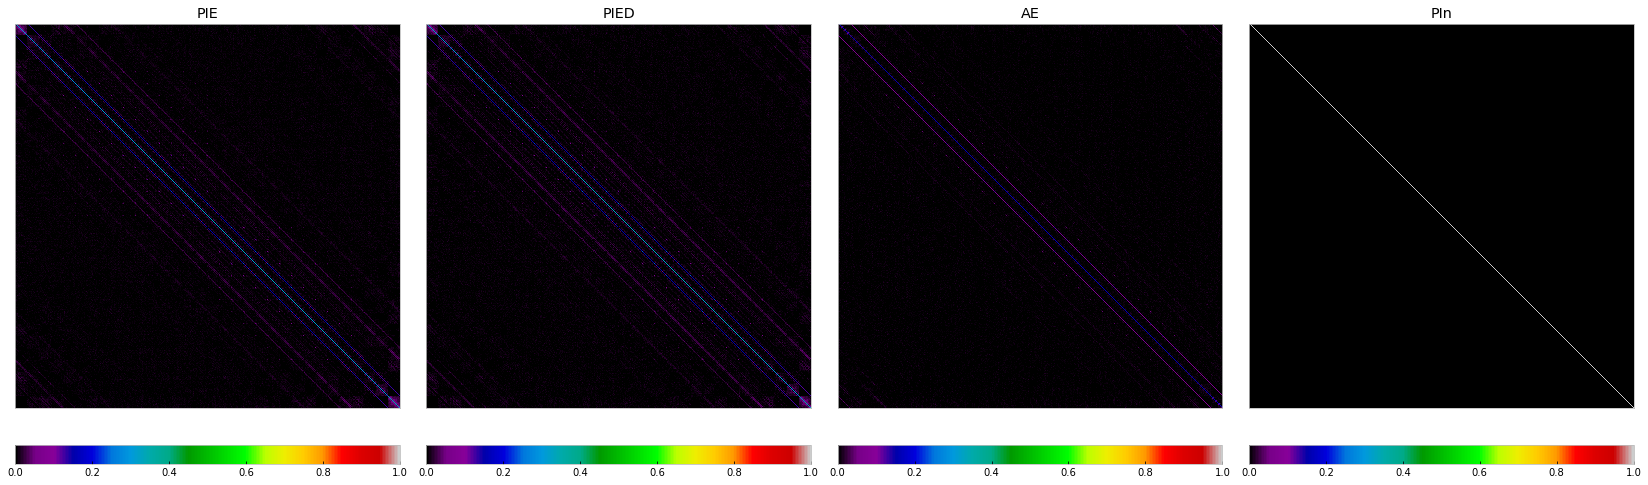

In [19]:
# Plot approximate identity operators
fig, axs = plt.subplots(1, len(Ids), figsize=(23,13))
for i, (k, I) in enumerate(Ids.items()):
    im = axs[i].matshow(I, cmap='nipy_spectral', vmin=0, vmax=1)
    axs[i].grid(False)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(f"{k}")
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04, orientation="horizontal")
    
plt.savefig(f'../figures/other/{experiment_name}_identities.pdf')

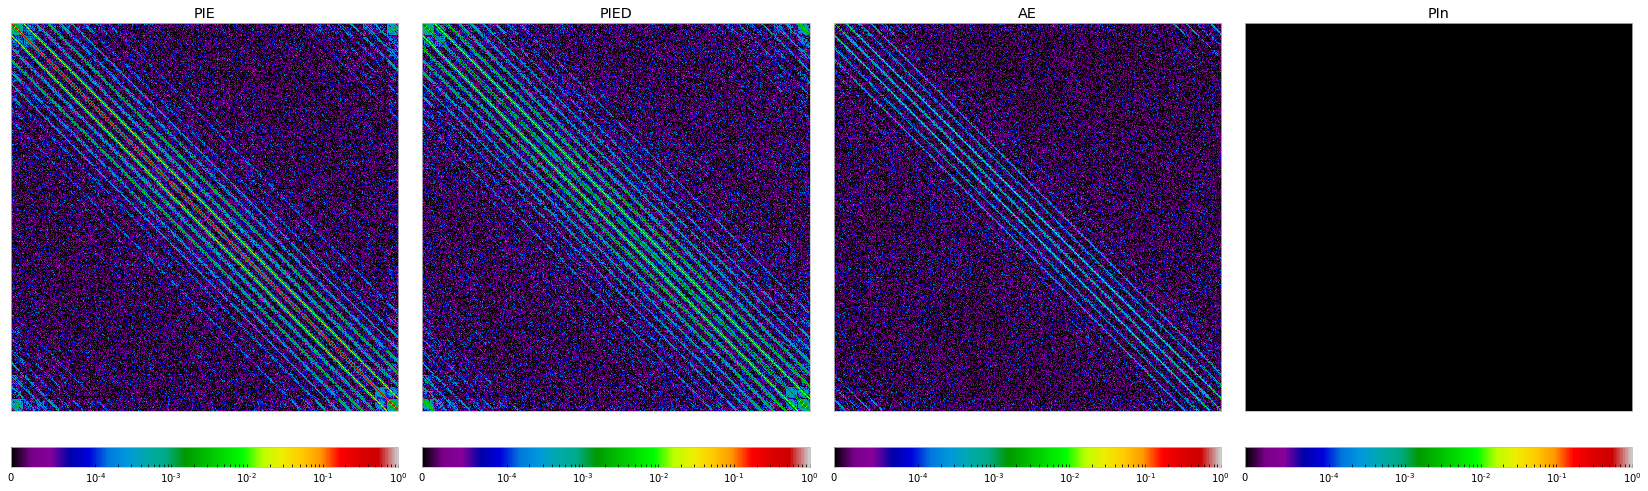

In [20]:
# Plot residuals (L2) of approximate identity operators

from matplotlib.colors import LogNorm, SymLogNorm

fig, axs = plt.subplots(1, len(Ids), figsize=(23,13))
for i, (k, I) in enumerate(Ids.items()):
    # Fix bug in LogNorm color
    res_I = (I - torch.eye(M))**2
    im = axs[i].matshow(res_I, cmap='nipy_spectral', norm=SymLogNorm(1e-4, vmax=1, base=10))
    axs[i].grid(False)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(f"{k}")
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04, orientation="horizontal")
    
plt.savefig(f'../figures/other/{experiment_name}_identities_residuals.pdf')

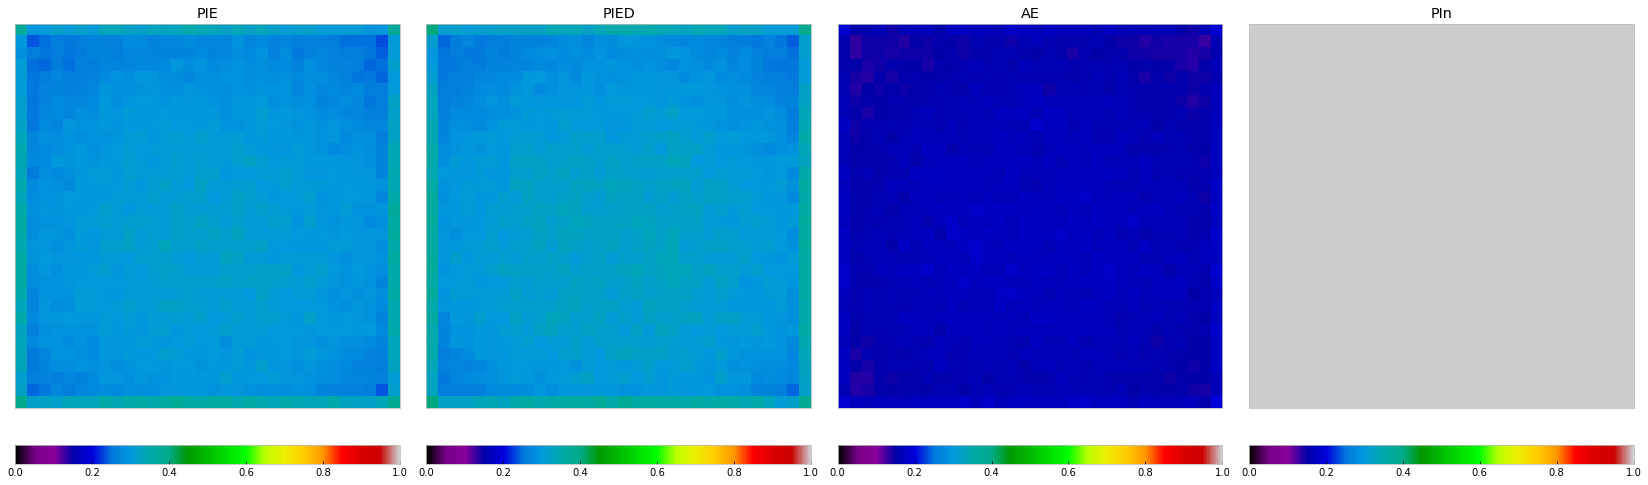

In [21]:
# Plot diagonal / tight frame coefficients
fig, axs = plt.subplots(1, len(Ids), figsize=(23,13))
ims = [None for _ in range(len(Ids))]
for i, (k, I) in enumerate(Ids.items()):
    d = torch.diag(I).unflatten(-1, train.size)
    im = axs[i].matshow(d, cmap='nipy_spectral', vmin=0, vmax=1)
    axs[i].grid(False)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(f"{k}")
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04, orientation="horizontal")
    
plt.savefig(f'../figures/other/{experiment_name}_diagarea.pdf')

In [22]:
# Calculate condition numbers
print("Condition Numbers:")
for i, (k, I) in enumerate(Ids.items()):
    kappa = torch.linalg.cond(I)
    print(f'{k:5} {kappa.item():5E}')

Condition Numbers:
PIE   3.162112E+07
PIED  2.061590E+07
AE    4.222850E+06
PIn   1.000836E+00


In [23]:
# Calculate approximate Lipshitz constants / spectral norms
print("Lipschitz Constants:")
for k, model in nets.items():
    dct = model.get_weight_dict()
    lipschitz_constants = torch.tensor([
        utils.metrics.stochastic_spectral_norm(w, 15) 
        for w in dct.values()
    ])
    lipschitz_product = torch.prod(lipschitz_constants)
    print(f'{k:5} {lipschitz_product.item():5E}')

Lipschitz Constants:
PIE   2.167211E+01
PIED  3.291937E+01
AE    1.458149E+01


In [24]:
# Calculate actual Lipshitz constants / spectral norms
print("Lipschitz Constants:")
for k, model in nets.items():
    dct = model.get_weight_dict()
    lipschitz_constants = torch.tensor([
        torch.svd(w)[1][0]
        for w in dct.values()
    ])
    lipschitz_product = torch.prod(lipschitz_constants)
    print(f'{k:5} {lipschitz_product.item():5E}')

Lipschitz Constants:
PIE   2.167211E+01
PIED  3.528067E+01
AE    1.486812E+01


In [25]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(M).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [26]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

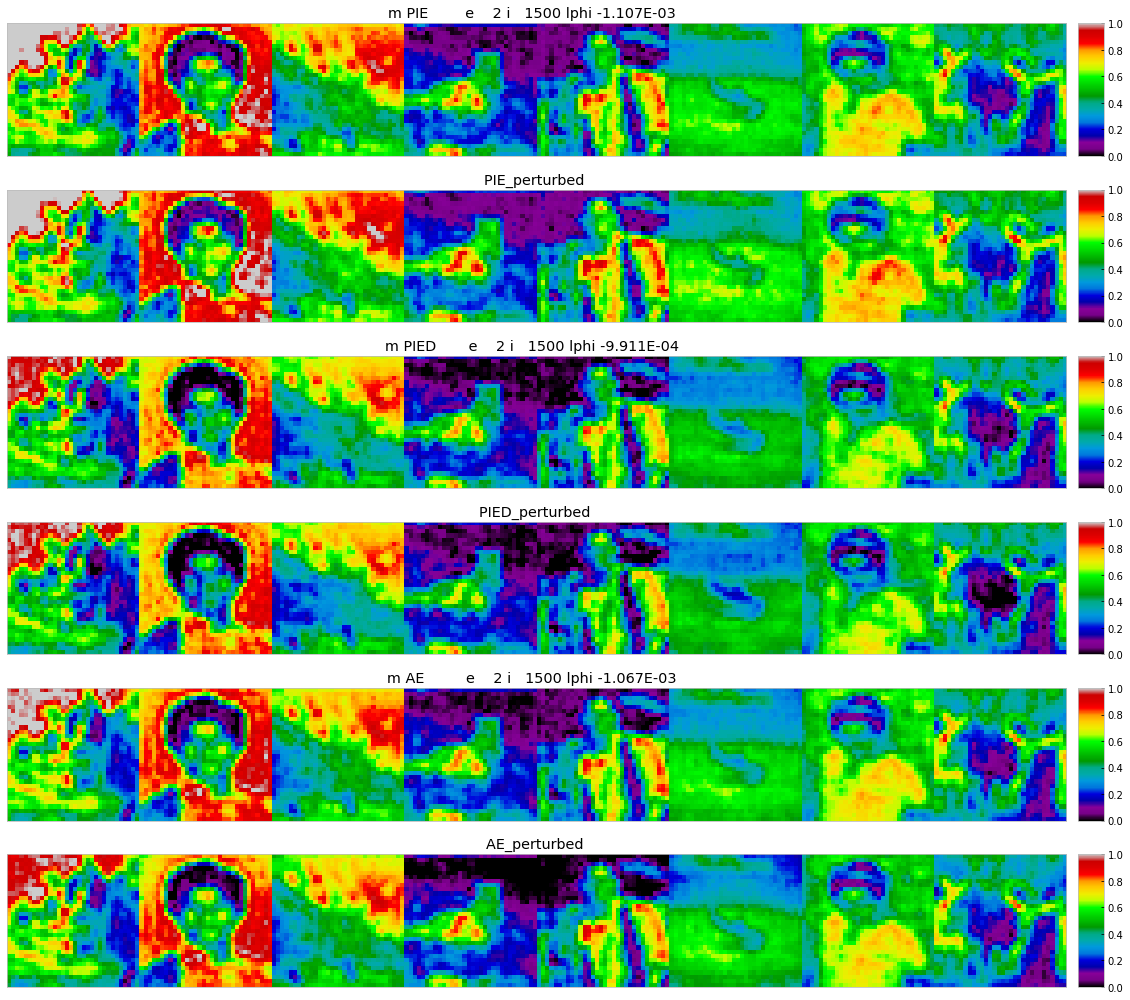

In [27]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            xh = nets[cur](x)
            xe = nets[cur](x + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = nets[cur].T(nets[cur](xs))
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
                    xhs[per] = nets[cur].T(nets[cur](xs + r))
                    xhs[per] = xhs[per].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

/itf-fi-ml/home/mariuaas/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/itf-fi-ml/home/mariuaas/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


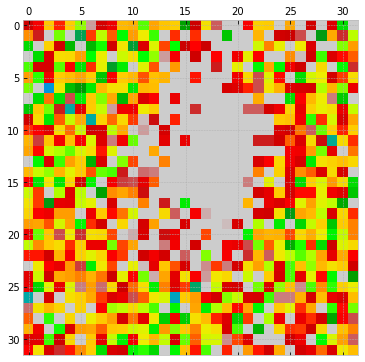

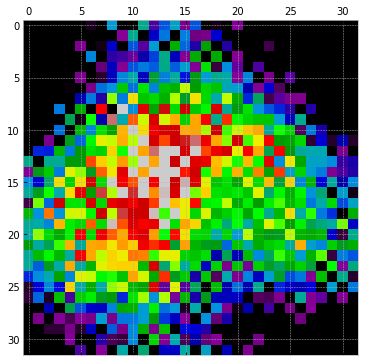

In [28]:
plt.matshow(rs['PIE'].to('cpu').unflatten(-1, train.size).detach(), vmin=-1, vmax=1)
plt.matshow(rs['AE'].to('cpu').unflatten(-1, train.size).detach(), vmin=-1, vmax=1)

In [ ]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

# Calculate relative error
print(f"Relative Error:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model.T(model(test_tensor + r))
    print(f"{k:6}: {utils.metrics.relative_error(test_tensor + rs[k].cpu(), XE, reduction='mean')}")


print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model.T(model(test_tensor + r))
    XH = model.T(model(test_tensor))

    rerr_psi = utils.metrics.relative_error(XH, XE, reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor, test_tensor + r, reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH, XE, test_tensor, r, reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Error:
PIE   : 0.6107538342475891
PIED  : 0.9403789043426514
AE    : 1.074813723564148
Relative Cond:
PIE   : 0.072898 0.065052 3.934551
PIED  : 0.072184 0.065052 3.896012


In [30]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [32]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [9]:
# Load models

serialized_path = f'../serialized/experiments/{experiment_name}/'
for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'rb') as outfile:
        nets[name] = torch.load(outfile)

In [10]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(M).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [11]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

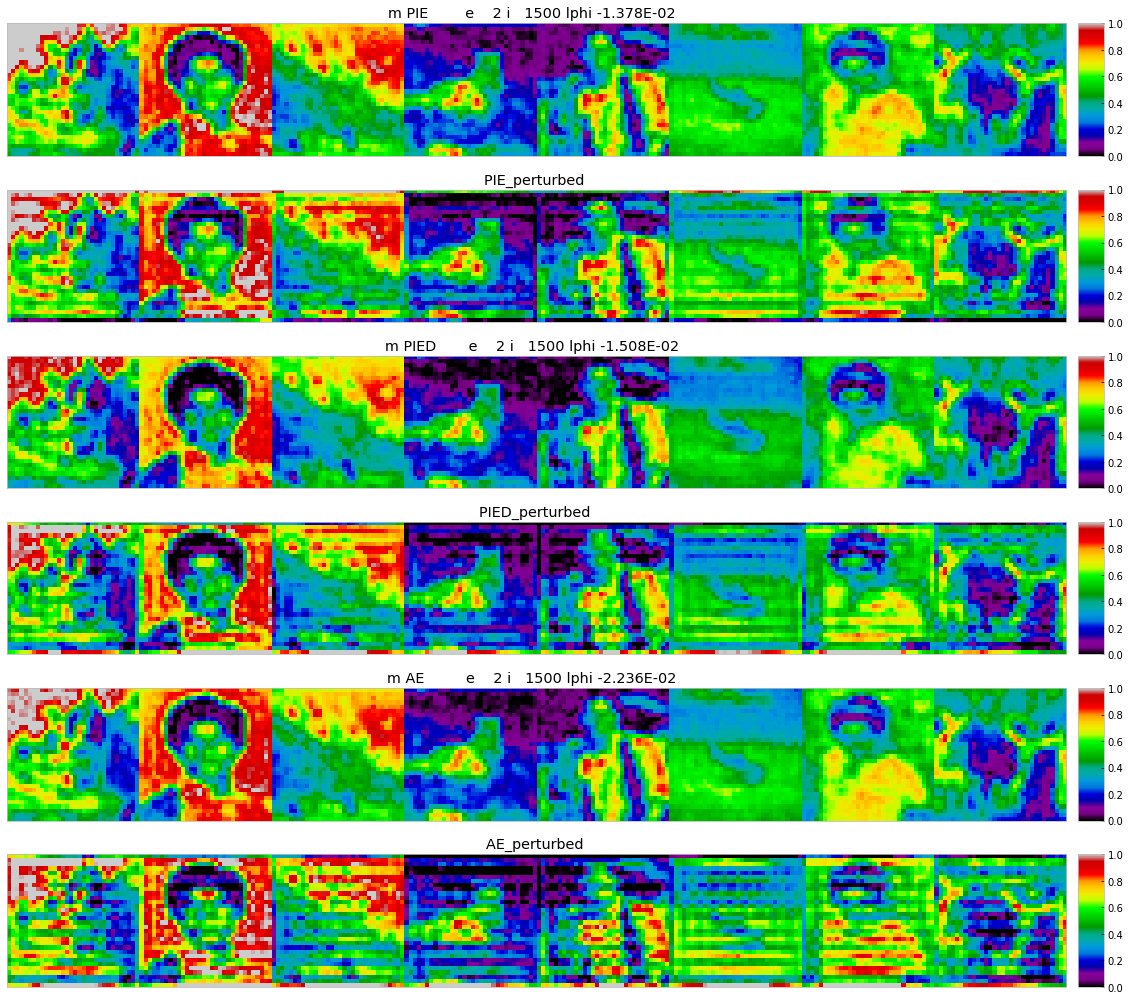

In [12]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        with torch.no_grad():
            y = blur_gpu(x.to(device)).flatten(-3, -1)
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            xh = nets[cur].T(y)
            xe = nets[cur].T(y + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = nets[cur].T(nets[cur](xs))
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
                    xhs[per] = nets[cur].T(nets[cur](xs) + r)
                    xhs[per] = xhs[per].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

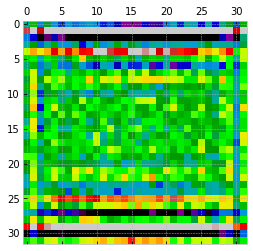

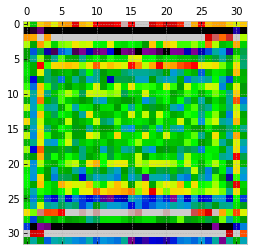

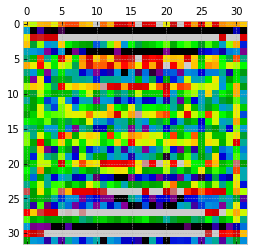

In [14]:
plt.matshow(rs['PIE'].to('cpu').unflatten(-1, train.size).detach(), vmin=-1, vmax=1)
plt.matshow(rs['PIED'].to('cpu').unflatten(-1, train.size).detach(), vmin=-1, vmax=1)
plt.matshow(rs['AE'].to('cpu').unflatten(-1, train.size).detach(), vmin=-1, vmax=1)

In [15]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    YE = model.T(yt.cpu() + r)
    YH = model.T(yt.cpu())

    cond_no = utils.metrics.relative_cond_no(YH, YE, yt.cpu(), r, reduction='mean')
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
PIE   : 12.764812
PIED  : 13.983212
AE    : 16.644680
